# Intégrer une colonne population pour créer des features relatives à celles-ci

Grâce au CSV country_population_2020 pris de Kaggle, on rejoute pour chaque ligne une données Population qui correspond au pays.

In [2]:
import pandas as pd

##### Ajout de la population dan le DataSet #####

# Charger les données
population_df = pd.read_csv('country_population_2020.csv')
covid_df = pd.read_csv('data_etl_output.csv')

# Créer un dictionnaire de mapping pour les noms de pays qui diffèrent
country_name_mapping = {
    'Burma': 'Myanmar',
    'Congo (Brazzaville)': 'Congo',
    'Congo (Kinshasa)': 'DR Congo',
    'Czechia': 'Czech Republic (Czechia)',
    'Taiwan*': 'Taiwan',
    'US': 'United States',
    'West Bank and Gaza': 'State of Palestine',
    'Kosovo': 'Kosovo',  # Kosovo n'est pas dans le fichier population
    "Cote d'Ivoire": "Côte d'Ivoire",
    'Saint Kitts and Nevis': 'Saint Kitts & Nevis',
    'Saint Vincent and the Grenadines': 'St. Vincent & Grenadines',
    'Sao Tome and Principe': 'Sao Tome & Principe'
}

# Ajout manuel de la population du Kosovo car vide
kosovo_data = pd.DataFrame({
    'Country (or dependency)': ['Kosovo'],
    'Population (2020)': [1920079],
    'Yearly Change': [""],
    'Net Change': [""],
    'Density (P/Km²)': [""],
    'Land Area (Km²)': [""],
    'Migrants (net)': [""],
    'Fert. Rate': [""],
    'Med. Age': [""],
    'Urban Pop %': [""],
    'World Share': [""]
})

# ajoute Kosovo dans population_df
population_df = pd.concat([population_df, kosovo_data], ignore_index=True)

# Nettoyer les noms de pays dans les deux dataframes
population_df['Country'] = population_df['Country (or dependency)'].str.strip()
covid_df['Country'] = covid_df['Country'].str.strip()

# Appliquer le mapping aux noms de pays dans covid_df
covid_df['Country'] = covid_df['Country'].replace(country_name_mapping)

# Fusionner les données en gardant toutes les lignes de covid_df
final_df = pd.merge(
    covid_df,
    population_df[['Country', 'Population (2020)']],
    on='Country',
    how='left'
)

# Renommer la colonne de population
final_df.rename(columns={'Population (2020)': 'Population'}, inplace=True)

# Création de features par rapport à la population et au temps écoulé entre chaque mesure

On rajoute des colonnes pour avoir :
- Le taux d'infections, de morts, et de guéris pour 100K habitants sur une population d'un pays
- La tendance d'infection d'un pays (sur une période de 3 mois)
- La moyenne mobile de chaque pays


In [3]:
##### Ajoute les colonnes Confirmed_per_100K, ... pour apporter de nouvelles metrics à nos modèles #####

def calc_features(dataframe):
    dataframe["Confirmed_per_100K"] = dataframe["Confirmed"] / (dataframe["Population"] / 100000)
    dataframe["Deaths_per_100K"] = dataframe["Deaths"] / (dataframe["Population"] / 100000)
    dataframe["Recovered_per_100K"] = dataframe["Recovered"] / (dataframe["Population"] / 100000)
    
    ##### Calcul des tendances et moyennes mobiles #####
    for col in ['Confirmed', 'Deaths', 'Recovered']:
        dataframe[f'{col}_rolling_avg3'] = dataframe.groupby('Country')[col].transform(
            lambda x: x.rolling(3, min_periods=1).mean()
        )
        
        dataframe[f'{col}_trend'] = dataframe.groupby('Country')[col].transform(
            lambda x: x.diff().rolling(3, min_periods=1).mean().fillna(0)
        )

calc_features(final_df)

# Vérification et correction des données

On vérifie la cohérence de nos données.

## Population
Si une donnée est manquante on essaie d'affecter la valeur population d'une autre ligne avec le même pays.
Si elles sont toutes vides, on lance un message d'alerte.

## Features
Si on a recalculé les valeurs dans Population, alors on refait les features XXX_per_100K, ...

In [4]:
##### Vérification et correction des valeurs négatives #####
# Pour les principales métriques COVID
isNeg = False

for col in ['Confirmed', 'Deaths', 'Recovered']:
    if (sum(final_df[col] < 0) > 0):
        isNeg = True
    final_df.loc[final_df[col] < 0, col] = 0
    print(f"{sum(final_df[col] < 0)} valeurs négatives corrigées dans {col}")

##### Correction des populations manquantes par pays #####
# 1. Identifier les lignes où la population est manquante ou <= 800 (Pop Vatican)
missing_pop_mask = final_df['Population'].isna() | (final_df['Population'] <= 800)

# 2. Grouper par pays et remplir les trous avec la première valeur valide trouvée dans le même pays
final_df['Population'] = final_df.groupby('Country')['Population'].transform(
    lambda x: x.fillna(x[x.notna() & (x > 800)].iloc[0] if any(x[x.notna() & (x > 800)]) else x)
)

# 3. Vérifier ce qui reste sans population
still_missing = final_df['Population'].isna() | (final_df['Population'] <= 800)

if still_missing.any():
    missing_countries = final_df[still_missing]['Country'].unique()
    print(f"AVERTISSEMENT : Population toujours manquante pour {len(missing_countries)} pays :")
    print(', '.join(missing_countries))
    
    # Option 1 : Exclure ces pays des métriques par habitant
    for col in ['Confirmed_per_100K', 'Deaths_per_100K', 'Recovered_per_100K']:
        final_df.loc[still_missing, col] = 0
    
##### Recalculer les métriques après corrections #####
# Recalculer les indicateurs normalisés si la population a été modifiée
if missing_pop_mask.any() | isNeg :  # Changed from missing_pop to missing_pop_mask
    calc_features(final_df)

print("\nVérifications de qualité terminées. Données prêtes pour l'analyse.")

0 valeurs négatives corrigées dans Confirmed
0 valeurs négatives corrigées dans Deaths
0 valeurs négatives corrigées dans Recovered

Vérifications de qualité terminées. Données prêtes pour l'analyse.


# Entrainement des données

Split 80/20 pour les données au vu de la taille du dataset

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Créer des colonnes décalées pour les prédictions
for col in ['Confirmed', 'Deaths', 'Recovered']:
    final_df[f'{col}_lag1'] = final_df.groupby('Country')[col].shift(1).fillna(0)

# Encoder les pays
le = LabelEncoder()
final_df['Country_encoded'] = le.fit_transform(final_df['Country'])

# Définir les features et la target
features = [
    'Confirmed_lag1', 'Deaths_lag1', 'Recovered_lag1', 'Country_encoded',
    'Confirmed_per_100K', 'Deaths_per_100K', 'Recovered_per_100K',
    'Confirmed_rolling_avg3', 'Deaths_rolling_avg3', 'Recovered_rolling_avg3',
    'Confirmed_trend', 'Deaths_trend', 'Recovered_trend'
]
targets = ['Confirmed', 'Deaths', 'Recovered']

X = final_df[features]
y = final_df[targets]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création des modèles

Liste des modèles créés :
- RandomForestRegressor
- XGBoostRegressor
- Keras Tensorflow

In [6]:
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rfr_model.fit(X_train[features], y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

In [7]:
from xgboost import XGBClassifier, XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='rmse'  # or 'mae', 'rmsle'
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [8]:
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Couche d'entrée
inputs = Input(shape=(X_train_scaled.shape[1],))

# Couches partagées
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)

# Sorties nommées explicitement
output_confirmed = Dense(1, name='Confirmed')(x)
output_deaths = Dense(1, name='Deaths')(x)
output_recovered = Dense(1, name='Recovered')(x)

# Création du modèle
keras_model = Model(inputs=inputs, outputs=[output_confirmed, output_deaths, output_recovered])

# Compilation avec les noms de sortie alignés
keras_model.compile(
    optimizer='adam',
    loss={'Confirmed': 'mse', 'Deaths': 'mse', 'Recovered': 'mse'},
    metrics={'Confirmed': 'mae', 'Deaths': 'mae', 'Recovered': 'mae'}
)

# Entraînement
history = keras_model.fit(
    X_train_scaled,
    {'Confirmed': y_train['Confirmed'], 'Deaths': y_train['Deaths'], 'Recovered': y_train['Recovered']},
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

In [9]:
# Sauvegarder le résultat
final_df.to_csv('mspr2_dataset.csv', index=False)

print("done")

done


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score
from sklearn.inspection import partial_dependence
from sklearn.model_selection import learning_curve, cross_val_score


def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    fig = plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()
    return fig

def plot_training_history(history, output_names, metrics=['loss', 'mae'], figsize=(15, 10)):
    """
    Plot training history for multiple outputs and metrics.
    
    Args:
        history: Keras history object or dictionary with training metrics
        output_names: List of output variable names
        metrics: List of metrics to plot (e.g., ['loss', 'mae'])
        figsize: Figure size
    """
    num_outputs = len(output_names)
    num_metrics = len(metrics)
    
    fig = plt.figure(figsize=figsize)
    
    for i, output in enumerate(output_names):
        for j, metric in enumerate(metrics):
            # Calculate subplot position
            pos = i * num_metrics + j + 1
            
            plt.subplot(num_outputs, num_metrics, pos)
            
            # Plot training and validation metrics
            train_key = f'{output}_{metric}'
            val_key = f'val_{output}_{metric}'
            
            if train_key in history.history:
                plt.plot(history.history[train_key], label='Train')
                plt.plot(history.history[val_key], label='Validation')
                
                # Formatting
                plt.title(f'{output} - {metric.upper()}')
                plt.ylabel(metric.upper())
                plt.xlabel('Epoch')
                plt.legend()
    
    plt.tight_layout()
    plt.show()
    return fig

def plot_performance_metrics(y_true, y_pred, output_names, figsize=(15, 6)):
    """
    Plot RMSE and R2 metrics as heatmaps.
    
    Args:
        y_true: Actual values (DataFrame or array)
        y_pred: Predicted values (array or list of arrays)
        output_names: List of output variable names
        figsize: Figure size
    """
    metrics = {'RMSE': [], 'R2': []}
    
    # Convert y_pred to 2D array if it's a list of arrays
    if isinstance(y_pred, list):
        y_pred = np.column_stack(y_pred)
    
    for i, target in enumerate(output_names):
        # Handle both DataFrame and array inputs
        if hasattr(y_true, 'values'):
            true_values = y_true[target].values if target in y_true else y_true[:, i]
        else:
            true_values = y_true[:, i]
            
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(true_values, y_pred[:, i]))
        r2 = r2_score(true_values, y_pred[:, i])
        
        metrics['RMSE'].append(rmse)
        metrics['R2'].append(r2)
    
    fig = plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    sns.heatmap(np.array([metrics['RMSE']]), 
                annot=True, fmt=".2f", cmap="YlOrRd",
                xticklabels=output_names, yticklabels=['RMSE'])
    plt.title("RMSE by Target Variable")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(np.array([metrics['R2']]), 
                annot=True, fmt=".4f", cmap="YlGn",
                xticklabels=output_names, yticklabels=['R²'])
    plt.title("R² Score by Target Variable")
    
    plt.tight_layout()
    plt.show()
    return fig

def plot_error_distribution(y_true, y_pred, output_names, figsize=(12, 4), bins=30):
    """
    Plot error distribution histograms for each output.
    
    Args:
        y_true: Actual values (DataFrame or array)
        y_pred: Predicted values (array or list of arrays)
        output_names: List of output variable names
        figsize: Figure size
        bins: Number of bins for histograms
    """
    # Convert y_pred to 2D array if it's a list of arrays
    if isinstance(y_pred, list):
        y_pred = np.column_stack(y_pred)
    
    fig = plt.figure(figsize=figsize)
    
    for i, output in enumerate(output_names):
        # Handle both DataFrame and array inputs
        if hasattr(y_true, 'values'):
            true_values = y_true[output].values if output in y_true else y_true[:, i]
        else:
            true_values = y_true[:, i]
            
        errors = true_values - y_pred[:, i]
        
        plt.subplot(1, len(output_names), i+1)
        plt.hist(errors, bins=bins)
        plt.title(f'{output} Error Distribution')
        plt.xlabel('Prediction Error')
        plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    return fig

def plot_mae_heatmap(y_true, y_pred, output_names, figsize=(10, 5)):
    """
    Plot MAE as a heatmap for multiple outputs.
    
    Args:
        y_true: Actual values (DataFrame or array)
        y_pred: Predicted values (array or list of arrays)
        output_names: List of output variable names
        figsize: Figure size
    """
    metrics = {'MAE': []}
    
    if isinstance(y_pred, list):
        y_pred = np.column_stack(y_pred)
    
    for i, target in enumerate(output_names):
        true_values = y_true[target].values if hasattr(y_true, 'values') else y_true[:, i]
        mae = mean_absolute_error(true_values, y_pred[:, i])
        metrics['MAE'].append(mae)
    
    fig = plt.figure(figsize=figsize)
    sns.heatmap(np.array([metrics['MAE']]), 
                annot=True, fmt=".2f", cmap="Blues",
                xticklabels=output_names, yticklabels=['MAE'])
    plt.title("Mean Absolute Error (MAE) by Target Variable")
    plt.tight_layout()
    plt.show()
    return fig

def plot_partial_dependence(model, X, feature_names, target_idx=0, 
                          figsize=(16, 10), horizontal_spacing=0.3, vertical_spacing=0.5):
    """
    Plot Partial Dependence for all features with adjustable spacing.
    
    Args:
        model: Trained model
        X: Input features
        feature_names: List of feature names
        target_idx: Target index for multi-output
        figsize: Overall figure size
        horizontal_spacing: Width between columns (as fraction of axis width)
        vertical_spacing: Height between rows (as fraction of axis height)
    """
    fig = plt.figure(figsize=figsize)
    n_cols = 3
    n_rows = int(np.ceil(len(feature_names) / n_cols))
    
    # Create gridspec with custom spacing
    gs = plt.GridSpec(n_rows, n_cols, wspace=horizontal_spacing, hspace=vertical_spacing)
    
    for i, feature in enumerate(feature_names):
        ax = plt.subplot(gs[i])
        
        # Compute PDP
        pdp = partial_dependence(
            model, X, [feature], 
            kind="average",
            grid_resolution=50
        )
        
        # Handle key names
        grid_key = 'grid_values' if 'grid_values' in pdp else 'values'
        avg_key = 'average' if 'average' in pdp else 'average_values'
        
        # Plot
        ax.plot(pdp[grid_key][0], pdp[avg_key][0])
        ax.set_title(f'PDP: {feature}', pad=15)  # Add title padding
        ax.set_xlabel(feature, labelpad=10)
        ax.set_ylabel('Partial Dependence', labelpad=10)
        
        # Add grid for readability
        ax.grid(alpha=0.2)
    
    # Adjust overall padding
    plt.tight_layout(pad=3.0)
    plt.show()
    return fig

def plot_cross_val_r2(model, X, y, targets, cv=5, model_name="Model", figsize=(15, 5)):
    """
    Plot cross-validated R² scores for multiple targets in a single row.
    
    Args:
        model: Trained model (RandomForest/XGBoost)
        X: Features
        y: Multi-output target DataFrame
        targets: List of target columns (e.g., ['Confirmed', 'Deaths', 'Recovered'])
        cv: Number of folds
        model_name: Model identifier for title
        figsize: Figure size
    """
    fig = plt.figure(figsize=figsize)
    
    for i, target in enumerate(targets, 1):
        # Calculate CV scores for each target
        scores = cross_val_score(model, X, y[target], cv=cv, scoring='r2')
        mean_score = np.mean(scores)
        
        # Create subplot for each target
        plt.subplot(1, len(targets), i)
        bars = plt.bar(range(1, cv+1), scores, color=['skyblue', 'salmon', 'lightgreen'][i-1])
        plt.axhline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.2f}')
        
        # Annotate bars with values
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height-0.05,
                    f'{height:.2f}', ha='center', color='white', weight='bold')
        
        plt.title(f'{target}', pad=10)
        plt.xlabel('Fold #')
        if i == 1:
            plt.ylabel('R² Score')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', alpha=0.3)
        plt.legend(loc='lower right')
    
    plt.suptitle(f'Cross-Validated R² Scores ({model_name})', y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()
    return fig

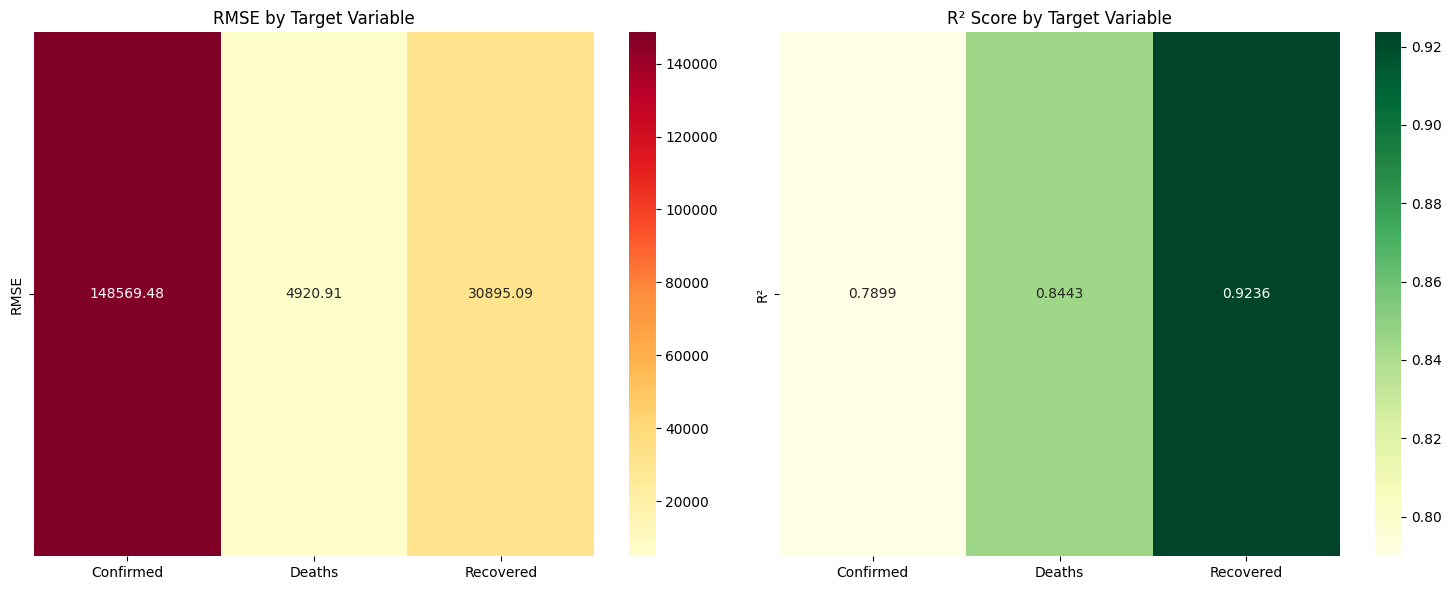

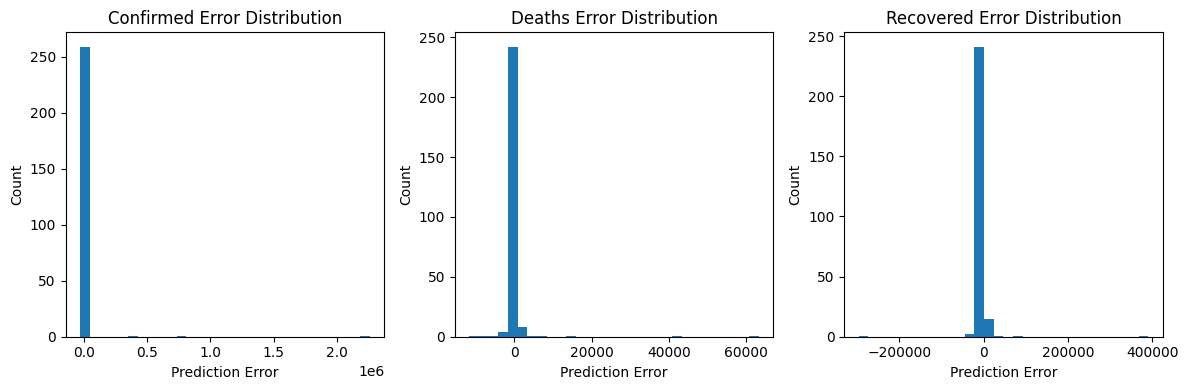

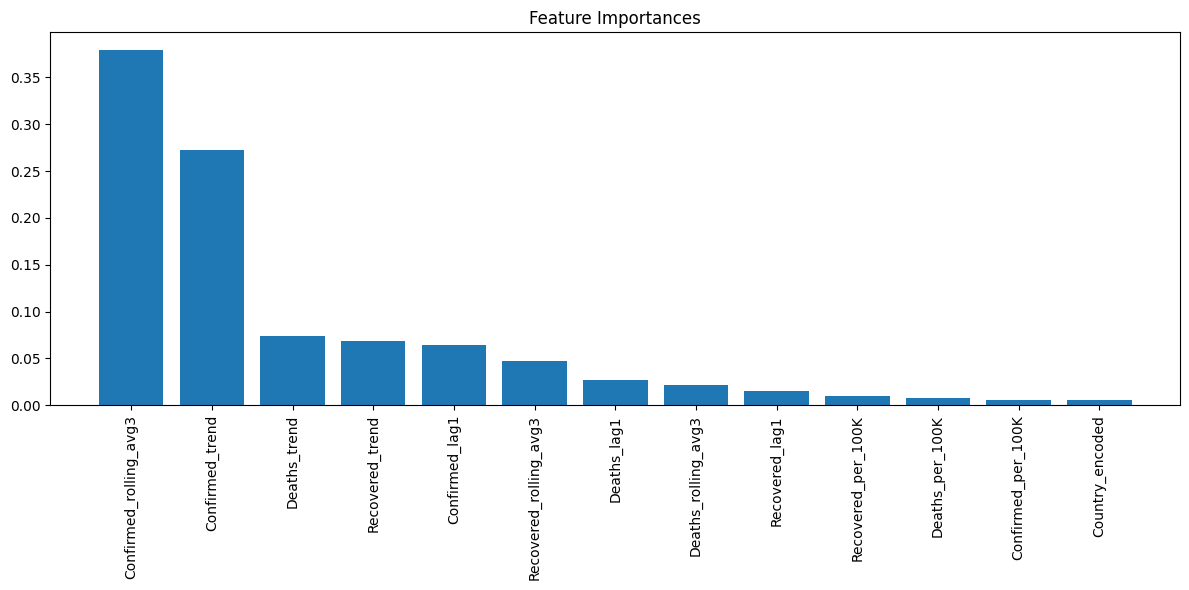

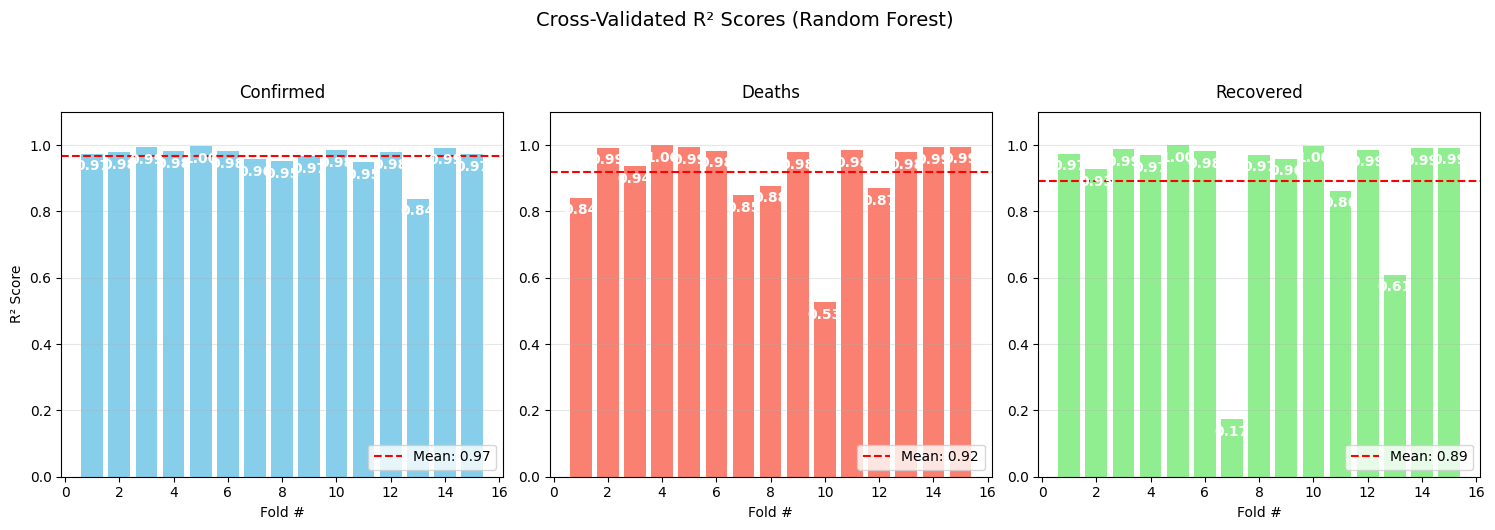

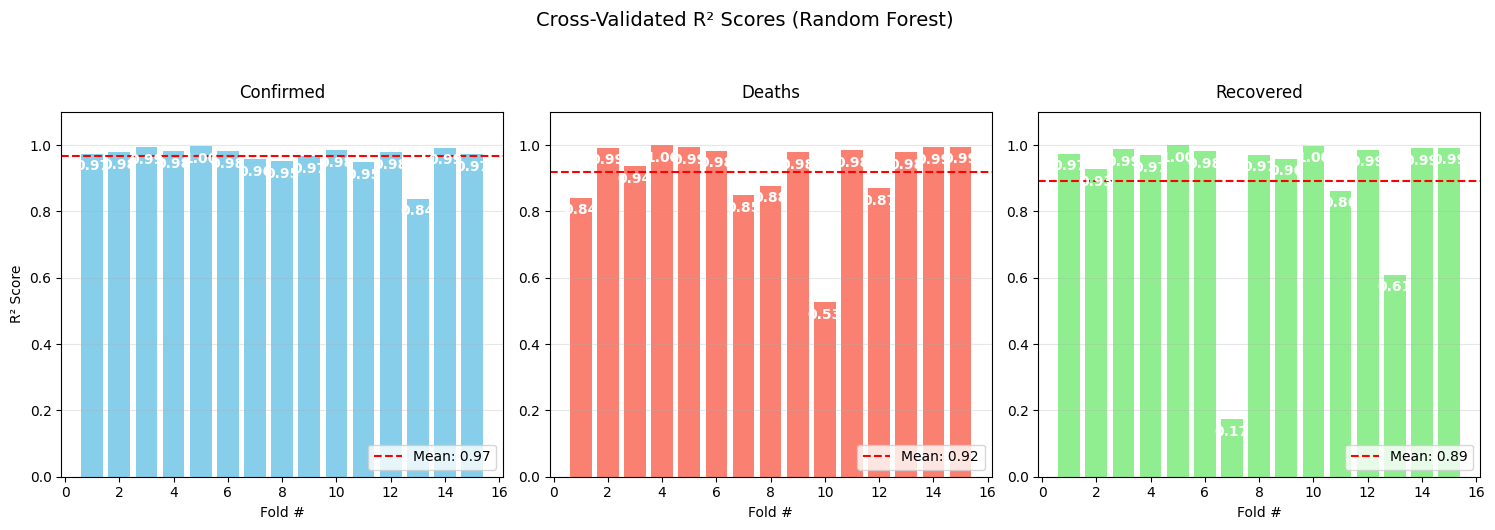

In [9]:
y_pred = rfr_model.predict(X_test)
outputs = ['Confirmed', 'Deaths', 'Recovered']

# For sklearn models, you might need to reshape y_pred if it's not already 2D
plot_performance_metrics(y_test, y_pred, outputs)
plot_error_distribution(y_test, y_pred, outputs)
plot_feature_importance(rfr_model, features)
plot_cross_val_r2(
    rfr_model, 
    X_train, 
    y_train,  # Ensure this is a DataFrame with all targets
    targets=outputs,
    cv=15,
    model_name="Random Forest"
)

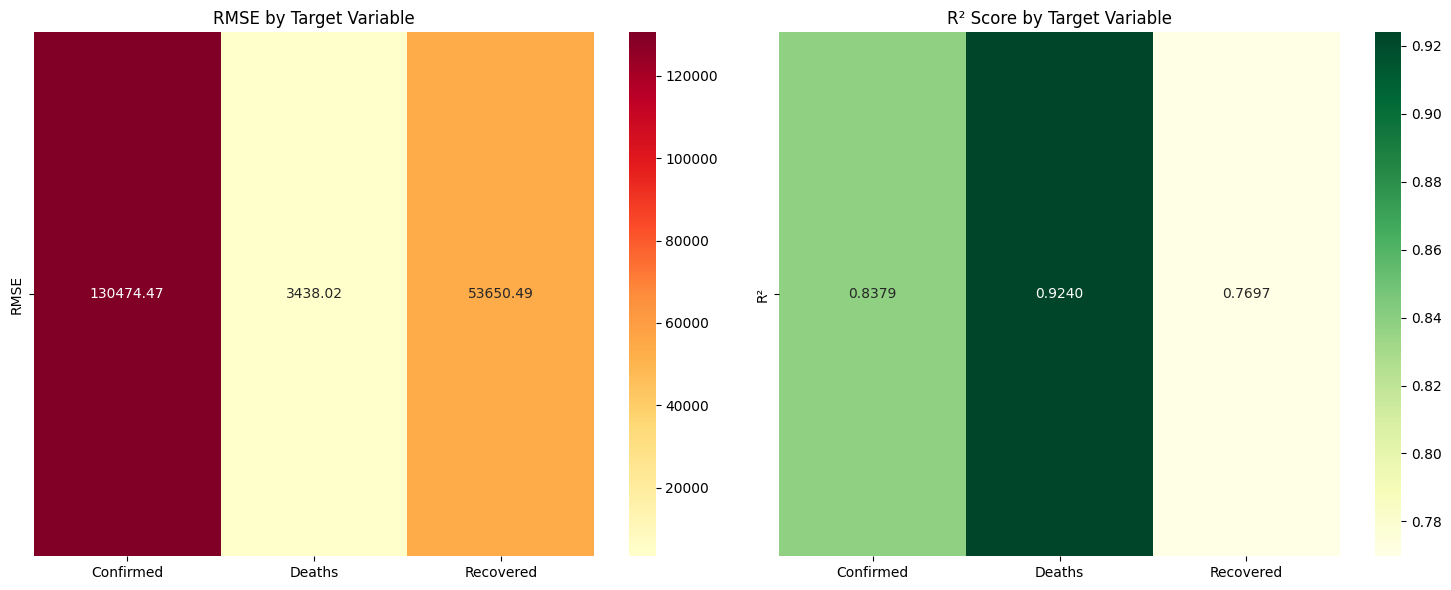

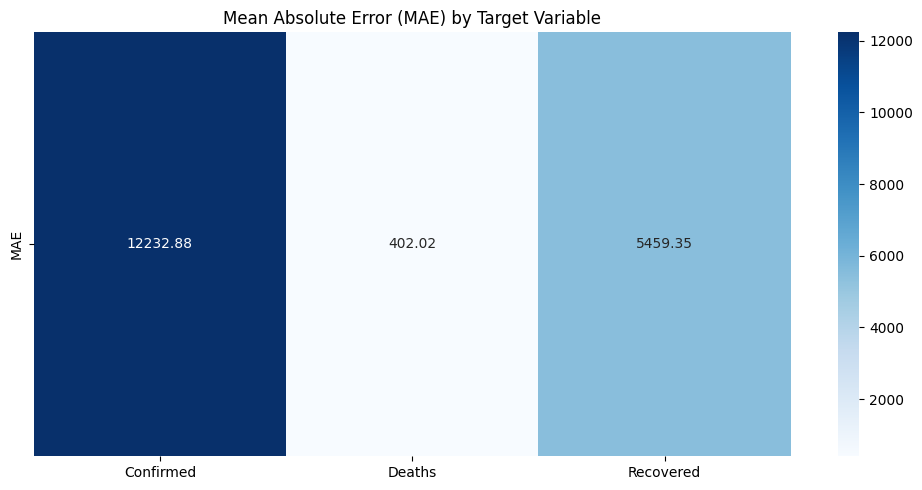

/tmp/ipykernel_23/3060697517.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


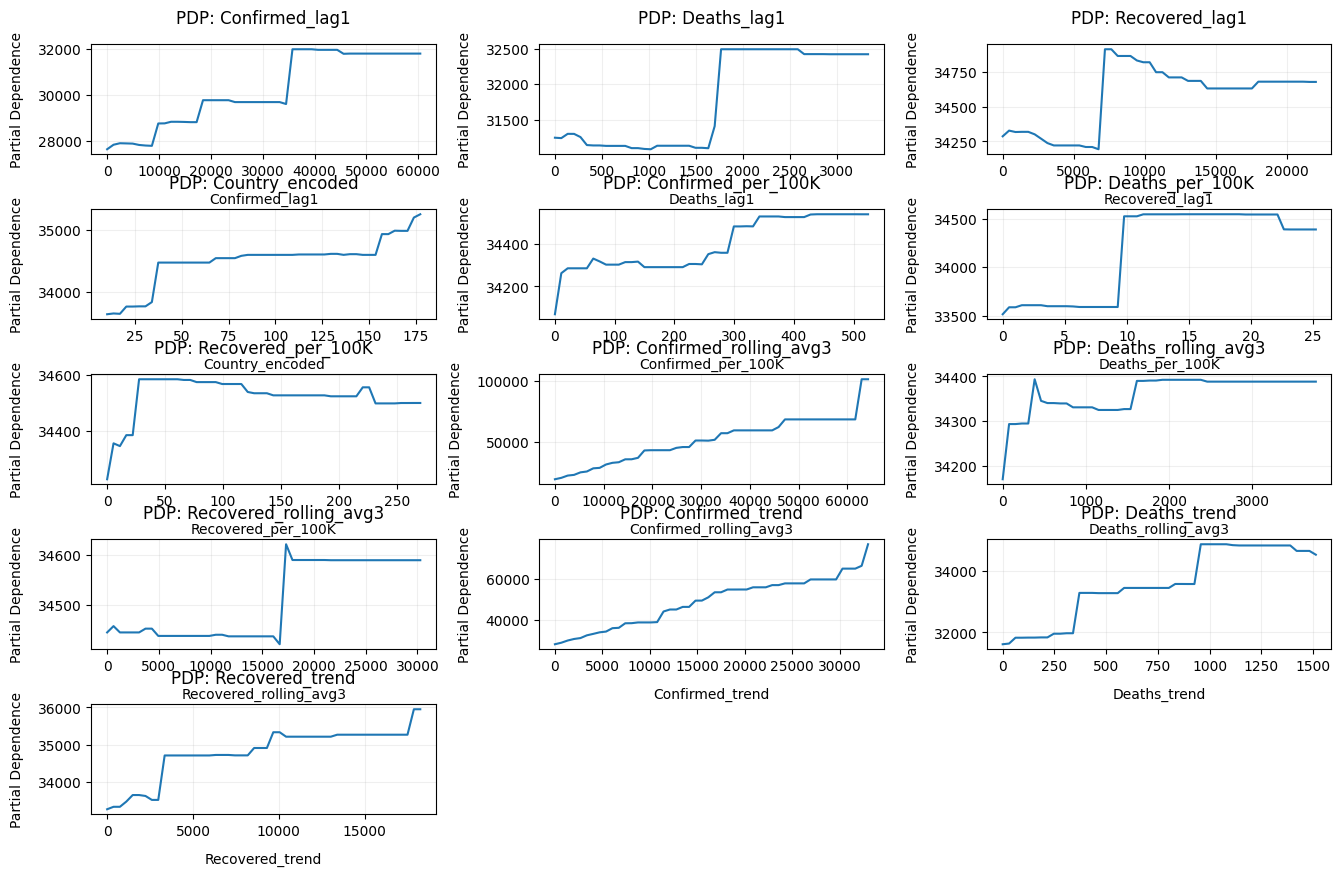

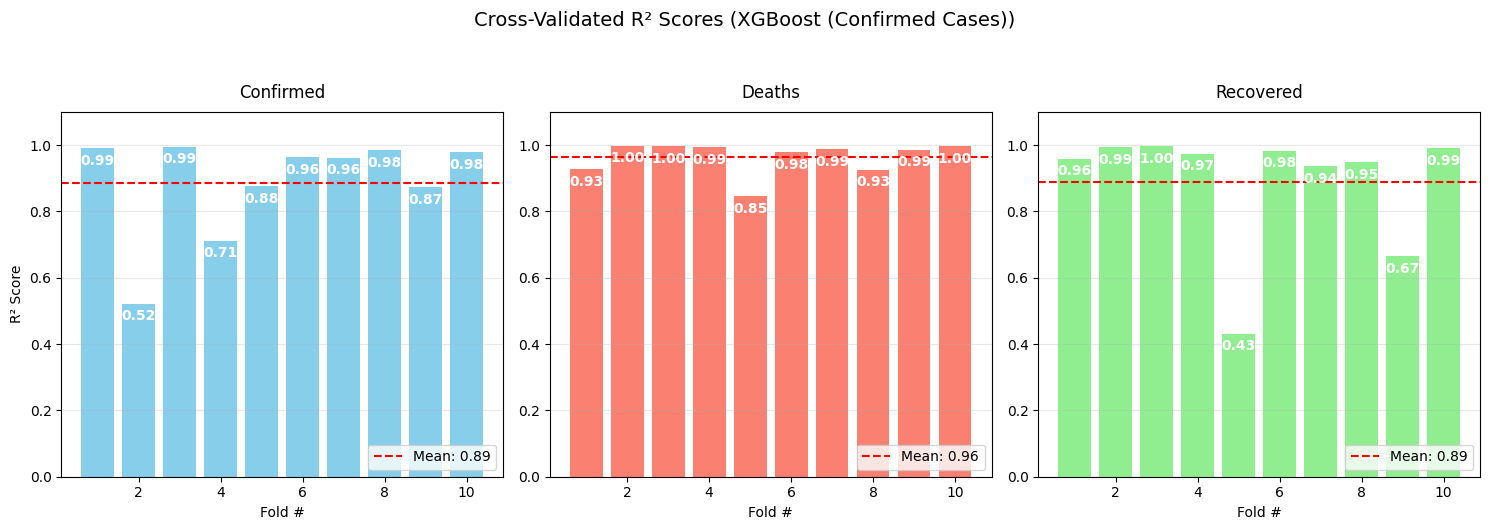

In [12]:
y_pred = xgb_model.predict(X_test)  # XGBoost outputs 2D arrays by default
outputs = ['Confirmed', 'Deaths', 'Recovered']
features = X_test.columns.tolist()  # List of feature names

plot_performance_metrics(y_test, y_pred, outputs)  # RMSE/R² heatmap
plot_mae_heatmap(y_test, y_pred, outputs)
plot_partial_dependence(xgb_model, X_test, features, target_idx=0)
plot_cross_val_r2(
    xgb_model, 
    X_train, 
    y_train,
    targets=outputs,
    cv=10, 
    model_name="XGBoost (Confirmed Cases)"
)

9/9 [==============================] - 0s 741us/step


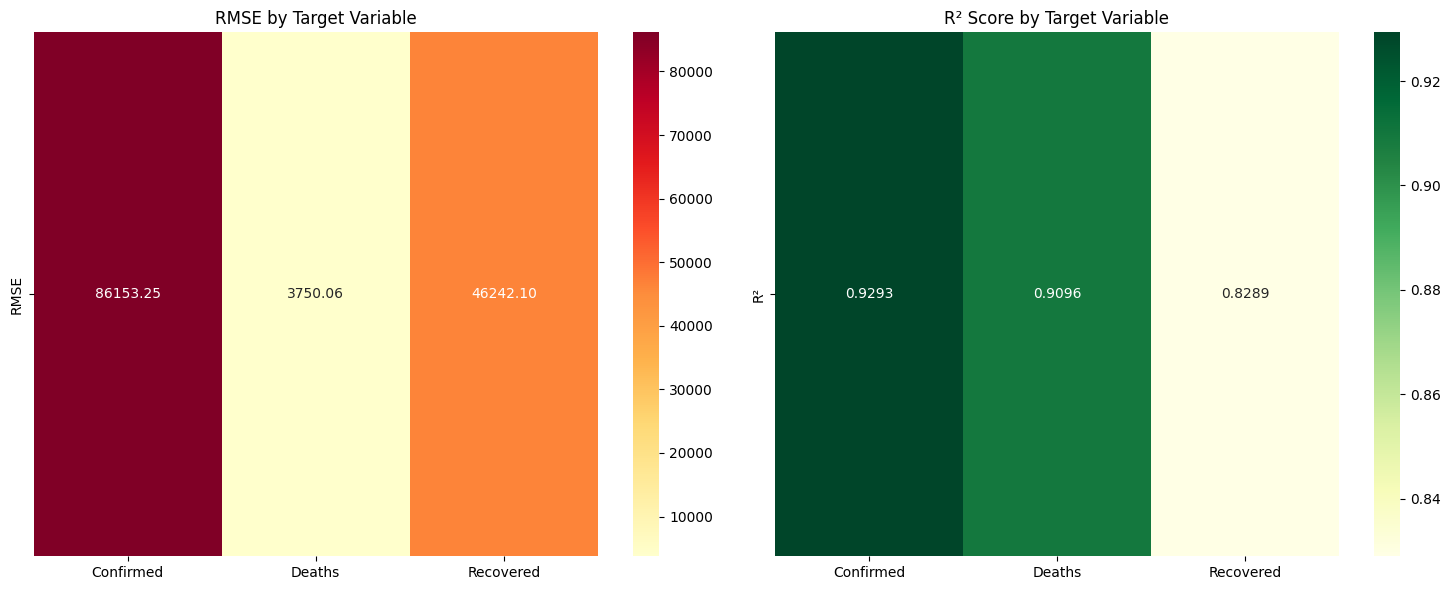

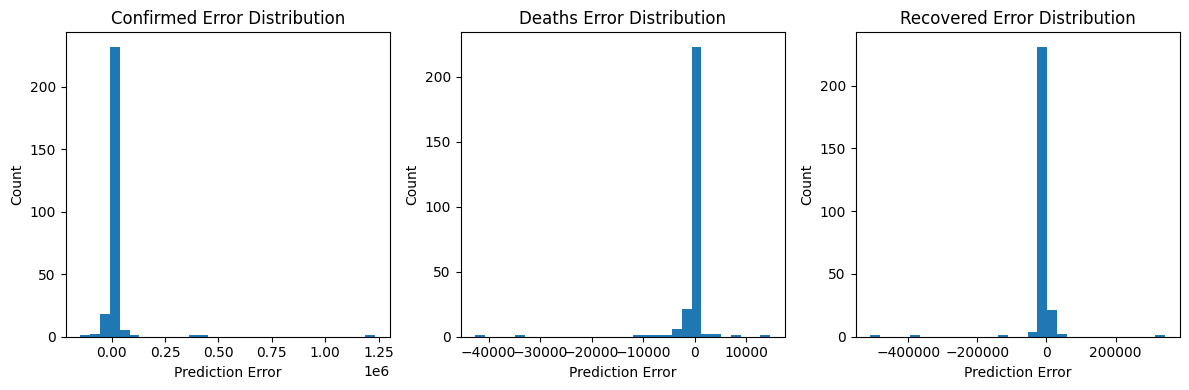

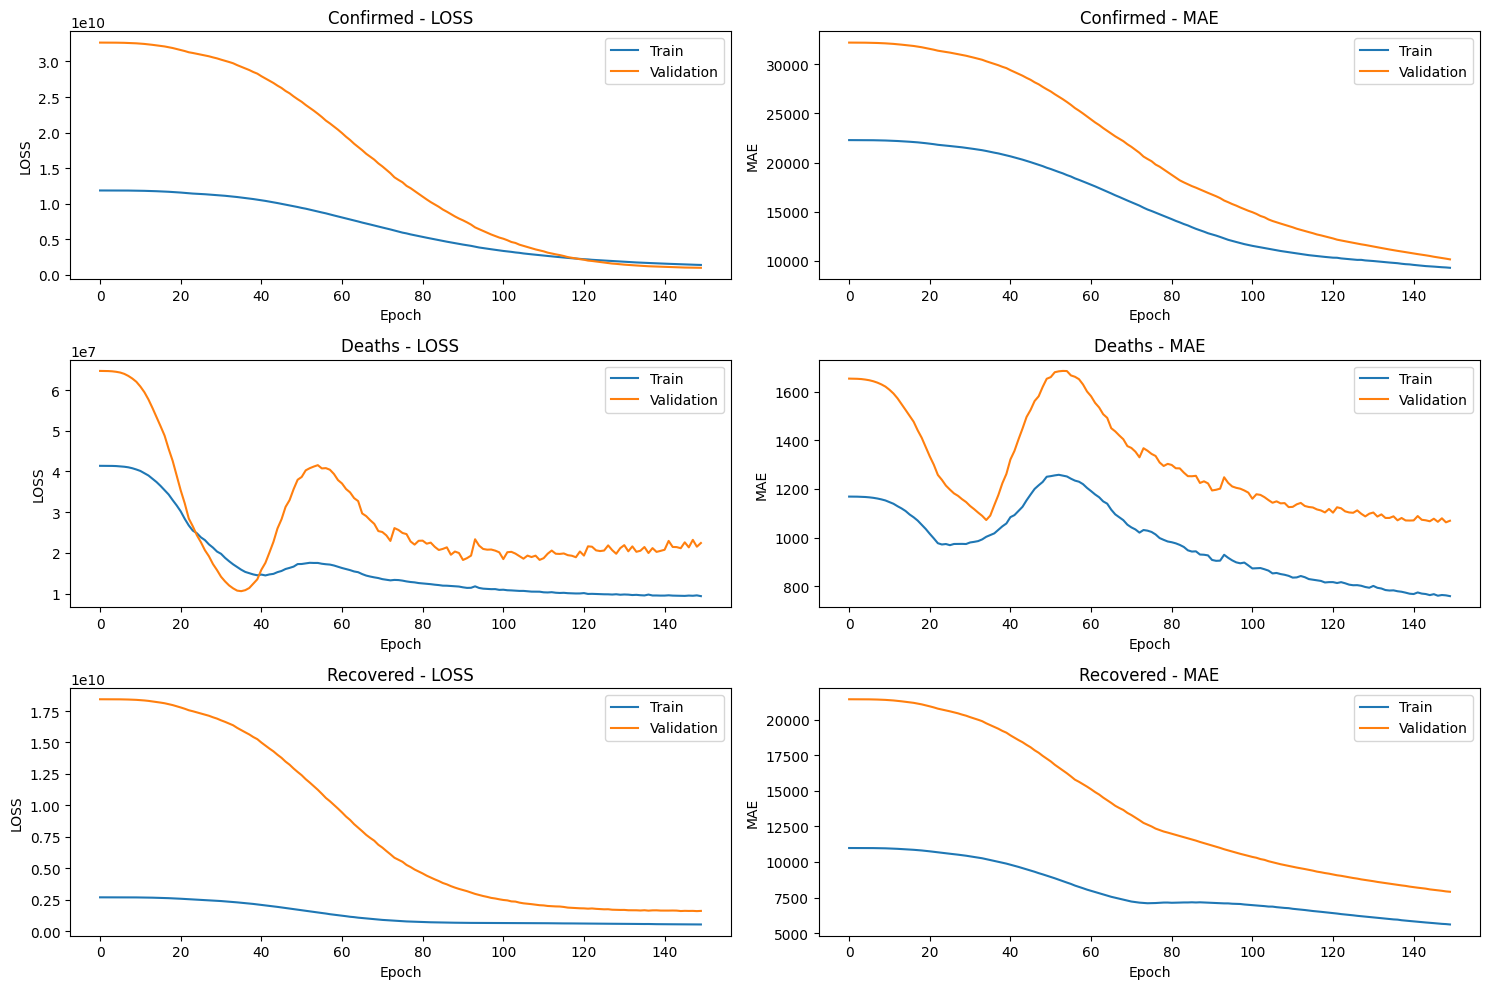

In [13]:
y_pred = keras_model.predict(X_test_scaled)
outputs = ['Confirmed', 'Deaths', 'Recovered']


plot_performance_metrics(y_test, y_pred, outputs)
plot_error_distribution(y_test, y_pred, outputs)
plot_training_history(history, outputs)

In [11]:
import pickle

# Save the model to a file
with open('model_v2.pkl', 'wb') as file:
    pickle.dump(rfr_model, file)

# Fonctions pour les artéfacts 

In [12]:
def plot_performance_metrics(y_true, y_pred, output_names, figsize=(15, 6)):
    """
    Plot RMSE and R2 metrics as heatmaps and return figure object.
    
    Args:
        y_true: Actual values (DataFrame or array)
        y_pred: Predicted values (array or list of arrays)
        output_names: List of output variable names
        figsize: Figure size
    """
    metrics = {'RMSE': [], 'R2': []}
    
    # Convert y_pred to 2D array if it's a list of arrays
    if isinstance(y_pred, list):
        y_pred = np.column_stack(y_pred)
    
    for i, target in enumerate(output_names):
        # Handle both DataFrame and array inputs
        if hasattr(y_true, 'values'):
            true_values = y_true[target].values if target in y_true else y_true[:, i]
        else:
            true_values = y_true[:, i]
            
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(true_values, y_pred[:, i]))
        r2 = r2_score(true_values, y_pred[:, i])
        
        metrics['RMSE'].append(rmse)
        metrics['R2'].append(r2)
    
    fig = plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    sns.heatmap(np.array([metrics['RMSE']]), 
                annot=True, fmt=".2f", cmap="YlOrRd",
                xticklabels=output_names, yticklabels=['RMSE'])
    plt.title("RMSE by Target Variable")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(np.array([metrics['R2']]), 
                annot=True, fmt=".4f", cmap="YlGn",
                xticklabels=output_names, yticklabels=['R²'])
    plt.title("R² Score by Target Variable")
    
    plt.tight_layout()
    return fig

def plot_feature_importance(model, feature_names, figsize=(12, 6)):
    """
    Plot feature importance as a bar chart and return figure object.
    
    Args:
        model: Trained model with feature_importances_ attribute
        feature_names: List of feature names
        figsize: Figure size
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    fig = plt.figure(figsize=figsize)
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    return fig

def plot_training_history(history, output_names, metrics=['loss', 'mae'], figsize=(15, 10)):
    """
    Plot training history for multiple outputs and metrics and return figure object.
    
    Args:
        history: Keras history object or dictionary with training metrics
        output_names: List of output variable names
        metrics: List of metrics to plot (e.g., ['loss', 'mae'])
        figsize: Figure size
    """
    num_outputs = len(output_names)
    num_metrics = len(metrics)
    
    fig = plt.figure(figsize=figsize)
    
    for i, output in enumerate(output_names):
        for j, metric in enumerate(metrics):
            pos = i * num_metrics + j + 1
            plt.subplot(num_outputs, num_metrics, pos)
            
            train_key = f'{output}_{metric}'
            val_key = f'val_{output}_{metric}'
            
            if train_key in history.history:
                plt.plot(history.history[train_key], label='Train')
                plt.plot(history.history[val_key], label='Validation')
                plt.title(f'{output} - {metric.upper()}')
                plt.ylabel(metric.upper())
                plt.xlabel('Epoch')
                plt.legend()
    
    plt.tight_layout()
    return fig

def plot_error_distribution(y_true, y_pred, output_names, figsize=(12, 4), bins=30):
    """
    Plot error distribution histograms for each output and return figure object.
    
    Args:
        y_true: Actual values (DataFrame or array)
        y_pred: Predicted values (array or list of arrays)
        output_names: List of output variable names
        figsize: Figure size
        bins: Number of bins for histograms
    """
    if isinstance(y_pred, list):
        y_pred = np.column_stack(y_pred)
    
    fig = plt.figure(figsize=figsize)
    
    for i, output in enumerate(output_names):
        true_values = y_true[output].values if hasattr(y_true, 'values') else y_true[:, i]
        errors = true_values - y_pred[:, i]
        
        plt.subplot(1, len(output_names), i+1)
        plt.hist(errors, bins=bins)
        plt.title(f'{output} Error Distribution')
        plt.xlabel('Prediction Error')
        plt.ylabel('Count')
    
    plt.tight_layout()
    return fig

def plot_mae_heatmap(y_true, y_pred, output_names, figsize=(10, 5)):
    """
    Plot MAE as a heatmap for multiple outputs and return figure object.
    
    Args:
        y_true: Actual values (DataFrame or array)
        y_pred: Predicted values (array or list of arrays)
        output_names: List of output variable names
        figsize: Figure size
    """
    metrics = {'MAE': []}
    
    if isinstance(y_pred, list):
        y_pred = np.column_stack(y_pred)
    
    for i, target in enumerate(output_names):
        true_values = y_true[target].values if hasattr(y_true, 'values') else y_true[:, i]
        mae = mean_absolute_error(true_values, y_pred[:, i])
        metrics['MAE'].append(mae)
    
    fig = plt.figure(figsize=figsize)
    sns.heatmap(np.array([metrics['MAE']]), 
                annot=True, fmt=".2f", cmap="Blues",
                xticklabels=output_names, yticklabels=['MAE'])
    plt.title("Mean Absolute Error (MAE) by Target Variable")
    plt.tight_layout()
    return fig

def plot_partial_dependence(model, X, feature_names, target_idx=0, figsize=(16, 10), 
                          horizontal_spacing=0.3, vertical_spacing=0.5):
    """
    Plot Partial Dependence for all features and return figure object.
    
    Args:
        model: Trained model
        X: Input features
        feature_names: List of feature names
        target_idx: Target index for multi-output
        figsize: Overall figure size
        horizontal_spacing: Width between columns
        vertical_spacing: Height between rows
    """
    fig = plt.figure(figsize=figsize)
    n_cols = 3
    n_rows = int(np.ceil(len(feature_names) / n_cols))
    
    gs = plt.GridSpec(n_rows, n_cols, wspace=horizontal_spacing, hspace=vertical_spacing)
    
    for i, feature in enumerate(feature_names):
        ax = plt.subplot(gs[i])
        pdp = partial_dependence(model, X, [feature], kind="average", grid_resolution=50)
        
        grid_key = 'grid_values' if 'grid_values' in pdp else 'values'
        avg_key = 'average' if 'average' in pdp else 'average_values'
        
        ax.plot(pdp[grid_key][0], pdp[avg_key][0])
        ax.set_title(f'PDP: {feature}', pad=15)
        ax.set_xlabel(feature, labelpad=10)
        ax.set_ylabel('Partial Dependence', labelpad=10)
        ax.grid(alpha=0.2)
    
    plt.tight_layout(pad=3.0)
    return fig

def plot_cross_val_r2(model, X, y, targets, cv=5, model_name="Model", figsize=(15, 5)):
    """
    Plot cross-validated R² scores for multiple targets and return figure object.
    
    Args:
        model: Trained model (RandomForest/XGBoost)
        X: Features
        y: Multi-output target DataFrame
        targets: List of target columns
        cv: Number of folds
        model_name: Model identifier for title
        figsize: Figure size
    """
    fig = plt.figure(figsize=figsize)
    
    for i, target in enumerate(targets, 1):
        scores = cross_val_score(model, X, y[target], cv=cv, scoring='r2')
        mean_score = np.mean(scores)
        
        plt.subplot(1, len(targets), i)
        bars = plt.bar(range(1, cv+1), scores, color=['skyblue', 'salmon', 'lightgreen'][i-1])
        plt.axhline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.2f}')
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height-0.05,
                    f'{height:.2f}', ha='center', color='white', weight='bold')
        
        plt.title(f'{target}', pad=10)
        plt.xlabel('Fold #')
        if i == 1:
            plt.ylabel('R² Score')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', alpha=0.3)
        plt.legend(loc='lower right')
    
    plt.suptitle(f'Cross-Validated R² Scores ({model_name})', y=1.05, fontsize=14)
    plt.tight_layout()
    return fig

In [ ]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.keras
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO

def log_combined_metrics(y_true, y_pred, prefix=""):
    """Calculate and log combined metrics for all targets"""
    metrics = {}
    
    # Handle different prediction formats
    if isinstance(y_pred, list):
        # Keras multi-output format (list of arrays)
        pred_arrays = [np.array(pred).flatten() for pred in y_pred]
    else:
        # Single array output (sklearn/xgboost)
        pred_arrays = [y_pred[:,i] if len(y_pred.shape) > 1 else y_pred for i in range(3)]
    
    # Calculate metrics for each target
    for i, target in enumerate(['Confirmed', 'Deaths', 'Recovered']):
        metrics[f'{target}_mae'] = mean_absolute_error(y_true[target], pred_arrays[i])
        metrics[f'{target}_mse'] = mean_squared_error(y_true[target], pred_arrays[i])
        metrics[f'{target}_rmse'] = np.sqrt(metrics[f'{target}_mse'])
        metrics[f'{target}_r2'] = r2_score(y_true[target], pred_arrays[i])
    
    # Calculate combined metrics (average)
    metrics['combined_mae'] = np.mean([metrics['Confirmed_mae'], metrics['Deaths_mae'], metrics['Recovered_mae']])
    metrics['combined_rmse'] = np.mean([metrics['Confirmed_rmse'], metrics['Deaths_rmse'], metrics['Recovered_rmse']])
    metrics['combined_r2'] = np.mean([metrics['Confirmed_r2'], metrics['Deaths_r2'], metrics['Recovered_r2']])
    
    # Log all metrics with prefix
    for name, value in metrics.items():
        mlflow.log_metric(f"{prefix}{name}", value)
    
    return metrics

def log_model_performance(model, X_train, y_train, X_test, y_test, model_name, model_type):
    """Unified function to log any model type with combined metrics and visualizations"""
    with mlflow.start_run(run_name=model_name):
        # Log model parameters and metadata
        mlflow.log_param("model_type", model_type)
        mlflow.log_param("features", ", ".join(features))
        mlflow.log_param("targets", ", ".join(targets))
        
        # Get predictions (handling each model type differently)
        if model_type == "keras":
            train_pred = model.predict(X_train)  # Returns list of arrays
            test_pred = model.predict(X_test)    # Returns list of arrays
        elif model_type == "random_forest":
            train_pred = model.predict(X_train[features])
            test_pred = model.predict(X_test[features])
        else:  # xgboost
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)
        
        # Log metrics
        train_metrics = log_combined_metrics(y_train, train_pred, "train_")
        test_metrics = log_combined_metrics(y_test, test_pred, "test_")
        
        # Log overfitting indicators
        mlflow.log_metric("mae_overfit_ratio", test_metrics['combined_mae'] / train_metrics['combined_mae'])
        mlflow.log_metric("rmse_overfit_ratio", test_metrics['combined_rmse'] / train_metrics['combined_rmse'])
        
        # Generate and log performance heatmaps
        output_names = ['Confirmed', 'Deaths', 'Recovered']
        
        # Training performance heatmap
        train_fig = plot_performance_metrics(y_train, train_pred, output_names)
        mlflow.log_figure(train_fig, "train_performance_heatmap.png")
        plt.close(train_fig)
        
        # Test performance heatmap
        test_fig = plot_performance_metrics(y_test, test_pred, output_names)
        mlflow.log_figure(test_fig, "test_performance_heatmap.png")
        plt.close(test_fig)
    
        # Test error distribution
        if model_type == "random_forest" or model_type == "keras":
            test_fig = plot_error_distribution(y_test, test_pred, output_names)
            mlflow.log_figure(test_fig, "error_distribution.png")
            plt.close(test_fig)

        # Test feature importance
        if model_type == "random_forest":
            fig = plot_feature_importance(model, features)
            mlflow.log_figure(fig, "feature_importance.png")
            plt.close(fig)

        # Test cross validation r2
        if model_type == "random_forest" or model_type == "xgboost":
            fig = plot_cross_val_r2(
                model=model,
                X=X_train,
                y=y_train,
                targets=output_names,
                cv=10,
                model_name=model_type
            )
            mlflow.log_figure(fig, "cross_validation_r2.png")
            plt.close(fig)

        # Tests MAE et partial dependances
        if model_type == "xgboost":
            fig = plot_mae_heatmap(y_test, test_pred, output_names)
            mlflow.log_figure(fig, "mae_heatmap.png")
            plt.close(fig)

            feature_names = [
                'Confirmed_lag1', 'Deaths_lag1', 'Recovered_lag1', 'Country_encoded',
                'Confirmed_per_100K', 'Deaths_per_100K', 'Recovered_per_100K',
                'Confirmed_rolling_avg3', 'Deaths_rolling_avg3', 'Recovered_rolling_avg3',
                'Confirmed_trend', 'Deaths_trend', 'Recovered_trend'
            ]
            fig = plot_partial_dependence(xgb_model, X_test, feature_names)
            mlflow.log_figure(fig, "partial_dependence.png")
            plt.close(fig)

        # Test Training history
        if model_type == "keras":
            fig = plot_training_history(history, output_names)
            mlflow.log_figure(fig, "training_history.png")
            plt.close(fig)
        
        # Log the model
        if model_type == "random_forest":
            mlflow.sklearn.log_model(model, "model")
        elif model_type == "xgboost":
            mlflow.xgboost.log_model(model, "model")
        elif model_type == "keras":
            mlflow.keras.log_model(model, "model")
            mlflow.sklearn.log_model(scaler, "scaler")

# Example usage remains the same:
mlflow.set_experiment("COVID_Predictions")

# For Random Forest
log_model_performance(
    rfr_model, 
    X_train, y_train, 
    X_test, y_test, 
    "Random_Forest", 
    "random_forest"
)

# For XGBoost
log_model_performance(
    xgb_model,
    X_train, y_train,
    X_test, y_test,
    "XGBoost_Model",
    "xgboost"
)

# For Keras
log_model_performance(
    keras_model,
    X_train_scaled, y_train,
    X_test_scaled, y_test,
    "Keras_Model",
    "keras"
)

2025/07/03 20:08:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
